## First Steps with TensorFlow

### Contant tensors and variables

In [3]:
import numpy as np
import tensorflow as tf

In [4]:
# np ndarrays are assignable
x = np.ones(shape=(2, 2))
x[0, 0] = 0.

print(f"{x = }")

x = array([[0., 1.],
       [1., 1.]])


In [6]:
# tf tensors are not
x = tf.ones(shape=(2, 2))
x[0, 0] = 0.


TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [9]:
# use variables instead to manage state
v = tf.Variable(initial_value=tf.ones(shape=(2, 2)))
print(f"{v = }")

v = <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>


In [10]:
v.assign(tf.zeros(shape=(2, 2)))
print(f"{v = }")

v = <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0., 0.],
       [0., 0.]], dtype=float32)>


In [11]:
# also works in subset of coefficients
v[0, 0].assign(3.)
print(f"{v = }")

v = <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[3., 0.],
       [0., 0.]], dtype=float32)>


you also have `assign_add()` and `addign_sub()`

### Tensorflow operations

In [14]:
a = tf.ones((2, 2))
print(f"{a = }")

b = tf.square(a)
print(f"{b = }")

c = tf.sqrt(a)
print(f"{c = }")

d = b + c
print(f"{d = }")

e = tf.matmul(a, b)
print(f"{e = }")

e *= d
print(f"{e = }")


a = <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>
b = <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>
c = <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>
d = <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 2.],
       [2., 2.]], dtype=float32)>
e = <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 2.],
       [2., 2.]], dtype=float32)>
e = <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[4., 4.],
       [4., 4.]], dtype=float32)>


### A second look at the GradientTape API

In [17]:
input_var = tf.Variable(initial_value=3.)

with tf.GradientTape() as tape:
    result = tf.square(input_var)

gradient = tape.gradient(result, input_var)

print(f"{gradient = }")

gradient = <tf.Tensor: shape=(), dtype=float32, numpy=6.0>


In [19]:
# only trainable variables are tracked by default, but you can specify any arbitrary tensor
input_const = tf.constant(3.)

with tf.GradientTape() as tape:
    tape.watch(input_const)
    result = tf.square(input_const)

gradient = tape.gradient(result, input_const)

print(f"{gradient = }")

gradient = <tf.Tensor: shape=(), dtype=float32, numpy=6.0>


In [21]:
# you can nest to calculate higher-order derivative
time = tf.Variable(0.)

with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position = 4.9 * time ** 2
    
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)

print(f"{speed = }")
print(f"{acceleration = }")

speed = <tf.Tensor: shape=(), dtype=float32, numpy=0.0>
acceleration = <tf.Tensor: shape=(), dtype=float32, numpy=9.8>


### End-to-end example: A linear classifier in pure TensorFlow

#### generating 2 classes or ranfom points in 2D

In [27]:
samples_per_class = 1_000

negative_samples = np.random.multivariate_normal(mean=[0, 3], cov=[[1, .5], [.5, 1]], size=samples_per_class)
positive_samples = np.random.multivariate_normal(mean=[3, 0], cov=[[1, .5], [.5, 1]], size=samples_per_class)

inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
print(f"{inputs.shape = }")

targets = np.vstack((
    np.zeros((samples_per_class, 1), dtype="float32"),
    np.ones((samples_per_class, 1), dtype="float32"),
))

print(f"{targets.shape = }")

inputs.shape = (2000, 2)
targets.shape = (2000, 1)


In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

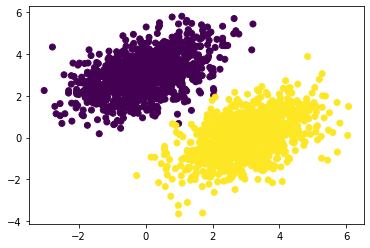

In [31]:
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

In [32]:
# lets train a linear classifier y = W @ inputs + b
input_dim = 2
output_dim = 1


W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim, )))

def model(inputs):
    return tf.matmul(inputs, W) + b

In [33]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

In [35]:
LR = .1

def train_step(inputs, targets):
    """"""
    # forward pass
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)

    # backwards
    grad_wrt_W, grad_wrt_b = tape.gradient(loss, [W, b])
    
    # step
    W.assign_sub(LR* grad_wrt_W)
    b.assign_sub(LR* grad_wrt_b)

    return loss

    

for simplicity, and since we have a small ds, we'll do GD instead og SGD

In [36]:
for step in range(40):
    loss = train_step(inputs, targets)
    print(f"{step = }: {loss = }")

step = 0: loss = <tf.Tensor: shape=(), dtype=float32, numpy=1.1120797>
step = 1: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.088712744>
step = 2: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.08198974>
step = 3: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.077011235>
step = 4: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.07256667>
step = 5: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.0685148>
step = 6: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.064810574>
step = 7: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.06142294>
step = 8: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.058324654>
step = 9: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.05549099>
step = 10: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.052899368>
step = 11: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.05052909>
step = 12: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.04836125>
step = 13: loss = <tf.Tensor: shape=(), dtype=float32, num

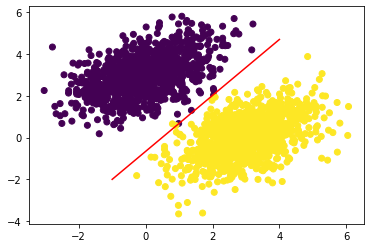

In [39]:
plt.figure()

# plot data
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])

# plot learned classifier
x = np.linspace(-1, 4, 100)
y = - W[0] / W[1] * x + (.5 - b) / W[1]

plt.plot(x, y, '-r')
plt.show()